In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})


In [2]:
from scipy.constants import e, m_p, c

from scipy.constants import physical_constants

In [3]:
from cpymad.madx import Madx

import pysixtracklib as pyst

In [4]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3
nmass = 0.931494061 # MAD-X value

### $\implies$ hard coded apertures in PySixTrackLib!!!

### $\implies$ missing dx, dy and dphi errors still!

# read in lattice from Vera

In [5]:
#filename_error_table = "./errors_84_73_1"

In [6]:
madx = Madx()
madx.options.echo = False
# madx.options.warn = False
# madx.options.info = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.04.02  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2018.10.03               +
  + Execution date: 2019.05.24 13:26:30      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [7]:
madxwarn = madx.options.warn
madx.options.warn = False
#madx.call(file=filename_error_table + '_full-lattice.seq')
# madx.call(file='./2019-05-23--100turns/SIS100RING_220618_nodipedge.thin.seq')
madx.call(file='./2019-05-24--100turns-onlyquad/SIS100QUADS.thin.seq')
madx.options.warn = madxwarn

In [8]:
madx.command.beam(particle='ion', mass=238*nmass, charge=28, energy=238*0.2+238*nmass)

True

In [9]:
madx.command.beam(particle='proton', energy=1)

True

In [10]:
madx.input('value, beam%sis100quads->gamma;')

beam%sis100quads->gamma =        1.065788933 ;


True

In [11]:
madx.input('value, beam%sis100quads->mass;')

beam%sis100quads->mass =       0.9382720813 ;


True

In [12]:
nmass_p = m_p/e*c**2
#nmass_p = 0.9382720813 * 1e9
nmass_p

938272081.4796857

In [13]:
Ekin = np.sqrt(1e9**2 - nmass_p**2)

In [14]:
# gamma recomputed to compare
np.sqrt((np.sqrt(1e9**2 - nmass_p**2) / nmass_p)**2 + 1)

1.065788932377661

In [15]:
madx.use(sequence='SIS100QUADS')

In [16]:
# madx.input('''
# select, flag=seqedit, class=collimator;
# select, flag=seqedit, class=hmonitor;
# select, flag=seqedit, class=vmonitor;
# select, flag=seqedit, class=kicker;
# select, flag=seqedit, class=tkicker;
# select, flag=seqedit, class=dipedge;
# select, flag=seqedit, class=elseparator;

# seqedit, sequence=SIS100RING;
#     remove, element=selected;
#     flatten;
# endedit;

# select, flag=seqedit, class=marker;
# seqedit, sequence=SIS100RING;
#     remove, element=selected;
#     install, element=SIS100RING$START, s=0;
#     flatten;
# endedit;
# ''')

In [17]:
madx.use(sequence='SIS100QUADS')

In [18]:
twiss = madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0   -3.330669074e-16       -54794158.01 

                q1                dq1            betxmax              dxmax 
       18.88000001       -65.92076631        19.86530221                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0        18.88000001 

               dq2            betymax              dymax              dyrms 
      -65.92076631        19.86530331                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [19]:
sis100 = madx.sequence.SIS100QUADS

In [20]:
[f.name for f in map(lambda x: x.base_type, sis100.expanded_elements) 
 if 'drift' != f.name and 'multipole' != f.name and 'rfcavity' != f.name]

['marker', 'marker']

# done, go to PySTL

In [48]:
elements = pyst.Elements.from_mad(sis100)

In [49]:
len(elements.get_elements())

339

In [50]:
nturns = 100 #2**16
elements.BeamMonitor(num_stores=nturns);

In [51]:
p0c = Ekin #238*0.2 * 1e9

In [52]:
npart = 1000
particles = pyst.Particles.from_ref(npart, p0c=p0c) #, q0=28, mass0=238*nmass*1e9)

In [53]:
particles.gamma0[0]

1.0657889324020815

In [54]:
madx.command.value('beam->gamma;')

beam->gamma        =        1.065788933 ;


True

In [55]:
filename_tracksumm = './2019-05-24--100turns-onlyquad/tracksumm_88_8_0_100'
#'./2019-05-24--100turns-onlyquad/track_AllCold_thin_one'
# './2019-05-23--100turns/tracksumm_84_73_1_100'

In [56]:
initial_distribution = np.genfromtxt(
    filename_tracksumm, skip_header=8)[:1000]
    #filename_tracksumm, skip_header=54)[:1000] #skip_footer=1000*19) #skip_header=8

In [57]:
!head -7 ./2019-05-23--100turns/tracksumm_84_73_1_100 | tail -1

In [58]:
headers = list(np.genfromtxt(
    filename_tracksumm, skip_header=6, skip_footer=2001, dtype=str)[1:]) #skip_header=6

In [59]:
initial_distribution.shape

(1000, 10)

In [60]:
final_distribution = np.genfromtxt(
    filename_tracksumm, skip_header=8 + 1000,)

In [61]:
final_distribution.shape

(1000, 10)

In [66]:
assert final_distribution.shape == initial_distribution.shape

In [65]:
assert final_distribution[0, 1] == nturns

In [67]:
x = initial_distribution[:, headers.index('X')]
xp = initial_distribution[:, headers.index('PX')]
y = initial_distribution[:, headers.index('Y')]
yp = initial_distribution[:, headers.index('PY')]
z = initial_distribution[:, headers.index('T')] * particles.beta0
dp = initial_distribution[:, headers.index('PT')] / particles.beta0**2

In [68]:
print ('sig_x: {}\nsig_y: {}\nsig_z: {}\nsig_dp: {}'.format(
    np.std(x), np.std(y), np.std(z), np.std(dp)))

sig_x: 0.008547358682435585
sig_y: 0.003615037276783371
sig_z: 0.0
sig_dp: 0.0


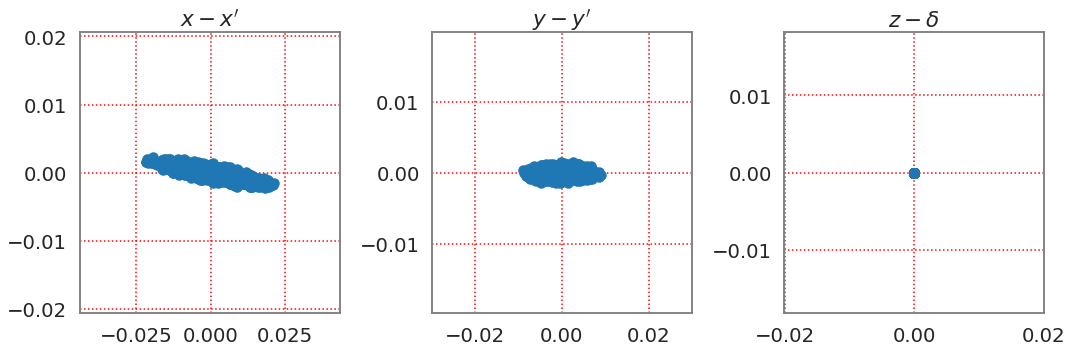

In [69]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.sca(ax[0])
plt.title('$x-x\'$')
plt.scatter(x, xp)

plt.sca(ax[1])
plt.title('$y-y\'$')
plt.scatter(y, yp)

plt.sca(ax[2])
plt.title('$z-\delta$')
plt.scatter(z, dp)
plt.tight_layout()

In [70]:
particles.x *= 0
particles.px *= 0
particles.y *= 0
particles.py *= 0
particles.zeta *= 0
particles.delta *= 0

particles.x += x
particles.px += xp
particles.y += y
particles.py += yp
particles.zeta += z
particles.delta += dp

In [71]:
job = pyst.TrackJob(elements, particles, device="opencl:1.0")

In [72]:
job.track(nturns)

0

In [73]:
job.collect()

In [74]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

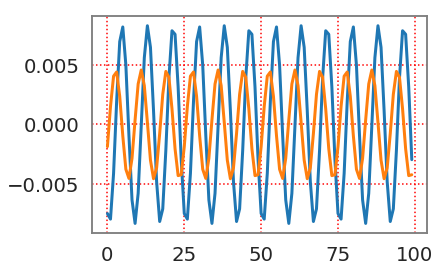

In [75]:
plt.plot(rec_x[1::npart])
plt.plot(rec_y[1::npart])

In [76]:
pbuffer = job.particles_buffer.get_object(0)

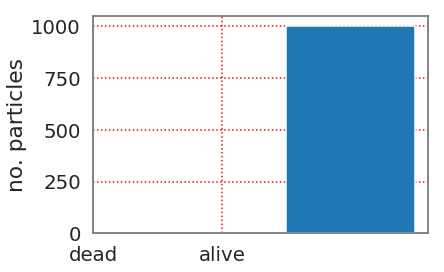

In [77]:
plt.hist(pbuffer.state, bins=2);
plt.ylabel('no. particles')
plt.xticks(ticks=[0.25, 0.75], labels=['dead', 'alive']);

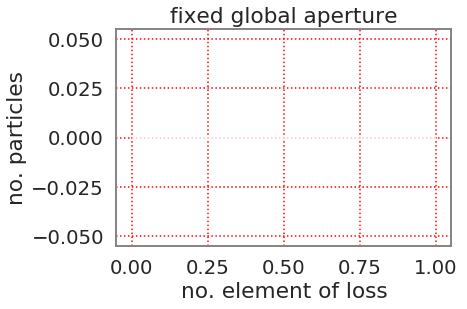

In [78]:
plt.title('fixed global aperture')
plt.hist(pbuffer.at_element[~pbuffer.state.astype(bool)]);
plt.ylabel('no. particles')
plt.xlabel('no. element of loss');

/opt/sixtracklib/virenv/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


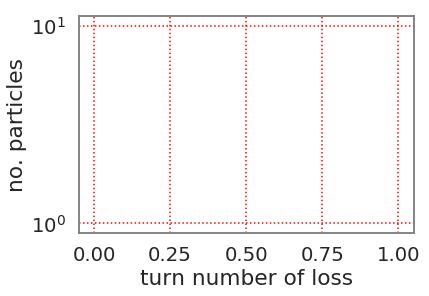

In [79]:
plt.hist(pbuffer.at_turn[~pbuffer.state.astype(bool)], bins=25);
plt.yscale('log')
plt.ylabel('no. particles')
plt.xlabel('turn number of loss');

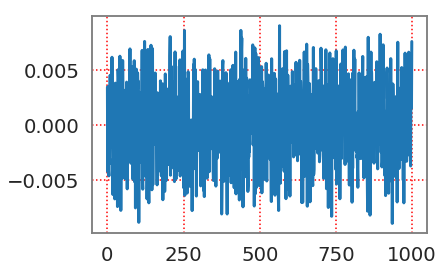

In [80]:
plt.plot(pbuffer.y)

In [81]:
Qx = twiss.summary['q1']
qx = Qx % 1
qx = qx if qx < 0.5 else 1 - qx

Qy = twiss.summary['q2']
qy = Qy % 1
qy = qy if qy < 0.5 else 1 - qy

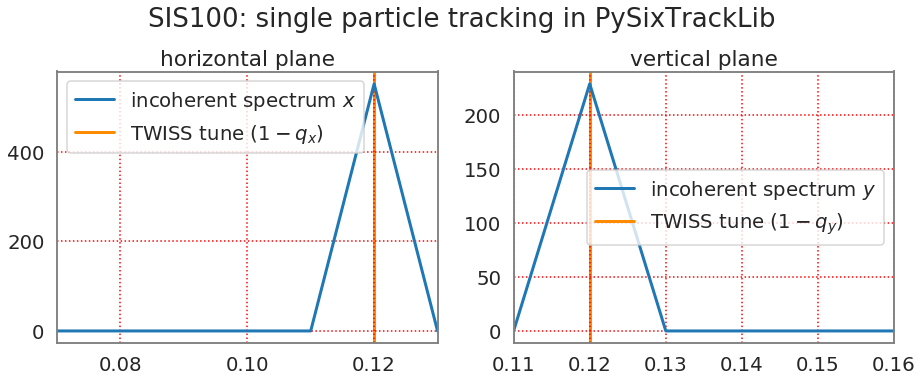

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(ax[0])
plt.title('horizontal plane')
plt.plot(
    np.fft.rfftfreq(len(rec_x[1::npart])),
    np.sum(np.abs(np.fft.rfft(rec_x.reshape(nturns, npart).T, axis=1)), axis=0),
    label=r'incoherent spectrum $x$'
)
plt.axvline(qx, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_x)$')
plt.xlim(qx - 0.05, qx + 0.01)
plt.legend()

plt.sca(ax[1])
plt.title('vertical plane')
plt.plot(
    np.fft.rfftfreq(len(rec_y[1::npart])),
    np.sum(np.abs(np.fft.rfft(rec_y.reshape(nturns, npart).T, axis=1)), axis=0),
    label=r'incoherent spectrum $y$'
)
plt.axvline(qy, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_y)$')
plt.xlim(qy - 0.01, qy + 0.04)
plt.legend()

plt.suptitle('SIS100: single particle tracking in PySixTrackLib', y=1.06, fontsize=26);
# plt.savefig('./pystl_sis100_tunes.pdf', bbox_inches='tight')

In [83]:
x = final_distribution[:, headers.index('X')]
xp = final_distribution[:, headers.index('PX')]
y = final_distribution[:, headers.index('Y')]
yp = final_distribution[:, headers.index('PY')]
z = final_distribution[:, headers.index('T')] * particles.beta0
dp = final_distribution[:, headers.index('PT')] / particles.beta0**2

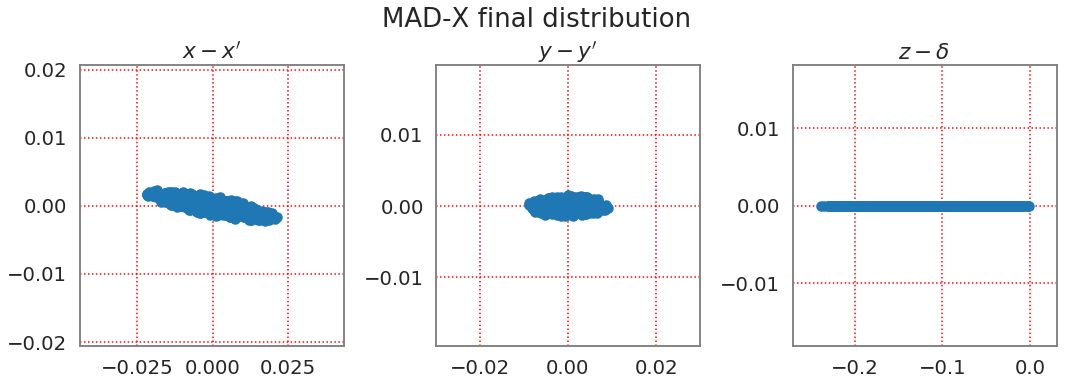

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.suptitle('MAD-X final distribution', fontsize=26, y=1.06)

plt.sca(ax[0])
plt.title('$x-x\'$')
plt.scatter(x, xp)

plt.sca(ax[1])
plt.title('$y-y\'$')
plt.scatter(y, yp)

plt.sca(ax[2])
plt.title('$z-\delta$')
plt.scatter(z, dp)
plt.tight_layout()

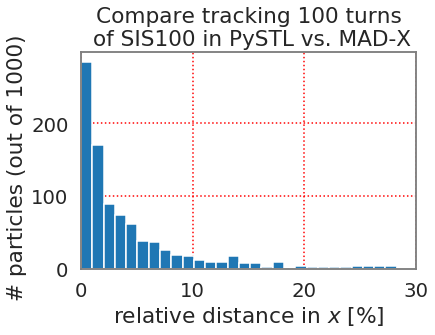

In [129]:
plt.hist(
    np.abs((pbuffer.x - final_distribution[:, headers.index('X')]) / pbuffer.x) * 100, 
    bins=np.linspace(0, 100, 100));
plt.xlim(0, 30)
plt.xlabel('relative distance in $x$ [%]')
plt.ylabel('# particles (out of {})  '.format(npart));
plt.title('Compare tracking 100 turns\n of SIS100 in PySTL vs. MAD-X')
plt.savefig('./tracking_madx_vs_pystl_x.pdf', bbox_inches='tight');

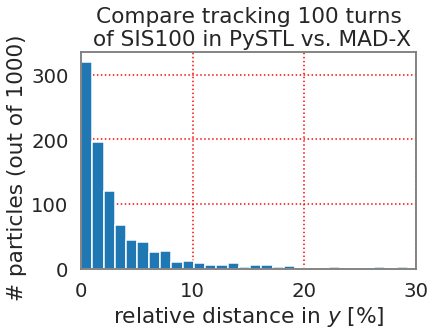

In [128]:
plt.hist(
    np.abs((pbuffer.y - final_distribution[:, headers.index('Y')]) / pbuffer.y) * 100, 
    bins=np.linspace(0, 100, 100));
plt.xlim(0, 30)
plt.xlabel('relative distance in $y$ [%]')
plt.ylabel('# particles (out of {})  '.format(npart));
plt.title('Compare tracking 100 turns\n of SIS100 in PySTL vs. MAD-X')
plt.savefig('./tracking_madx_vs_pystl_y.pdf', bbox_inches='tight');

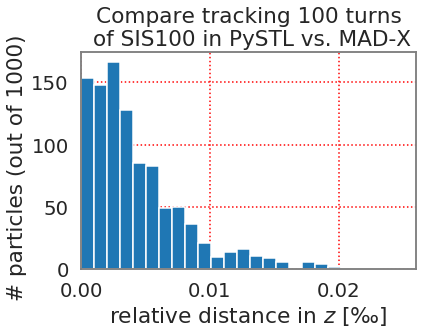

In [127]:
plt.hist(
    np.abs((pbuffer.zeta - final_distribution[:, headers.index('T')] * particles.beta0) / pbuffer.zeta) * 1000, 
    bins=np.linspace(0, 0.1, 100));
plt.xlim(0, 0.026)
plt.xlabel(u'relative distance in $z$ [‰]')
plt.ylabel('# particles (out of {})  '.format(npart));
plt.title('Compare tracking 100 turns\n of SIS100 in PySTL vs. MAD-X')
plt.savefig('./tracking_madx_vs_pystl_z.pdf', bbox_inches='tight');

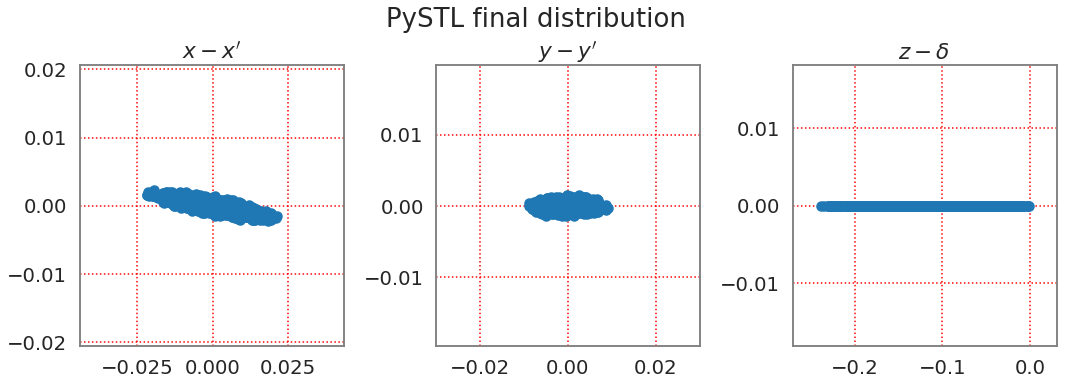

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.suptitle('PySTL final distribution', fontsize=26, y=1.06)

plt.sca(ax[0])
plt.title('$x-x\'$')
plt.scatter(pbuffer.x, pbuffer.px)

plt.sca(ax[1])
plt.title('$y-y\'$')
plt.scatter(pbuffer.y, pbuffer.py)

plt.sca(ax[2])
plt.title('$z-\delta$')
plt.scatter(pbuffer.zeta, pbuffer.delta)
plt.tight_layout()